In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
# Load datasets

data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Missing Values in the Training Dataset
Will be completed in the next step.

In [4]:
missing = data.isna().sum().loc[lambda x: x > 0].sort_values()
print('NAN values in train data:\n')
display(missing)

NAN values in train data:



Electrical         1
MasVnrArea         8
BsmtCond          37
BsmtFinType1      37
BsmtQual          37
BsmtExposure      38
BsmtFinType2      38
GarageType        81
GarageQual        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

# Outlier Analysis

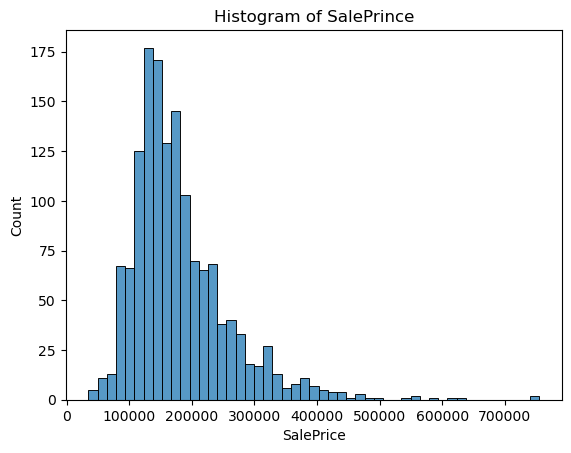

In [5]:
sns.histplot(data, x='SalePrice').set_title('Histogram of SalePrince')
plt.show()

# print(f"Houses with SalePrice > 500_000: {len(data[data['SalePrice']>500_000])}") # Output: 9

Correlation of X and SalePrice
EnclosedPorch   -0.128578
Id              -0.021917
BsmtFinSF2      -0.011378
ScreenPorch      0.111447
BsmtUnfSF        0.214479
LotArea          0.263843
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GrLivArea        0.708624
SalePrice        1.000000
Name: SalePrice, dtype: float64


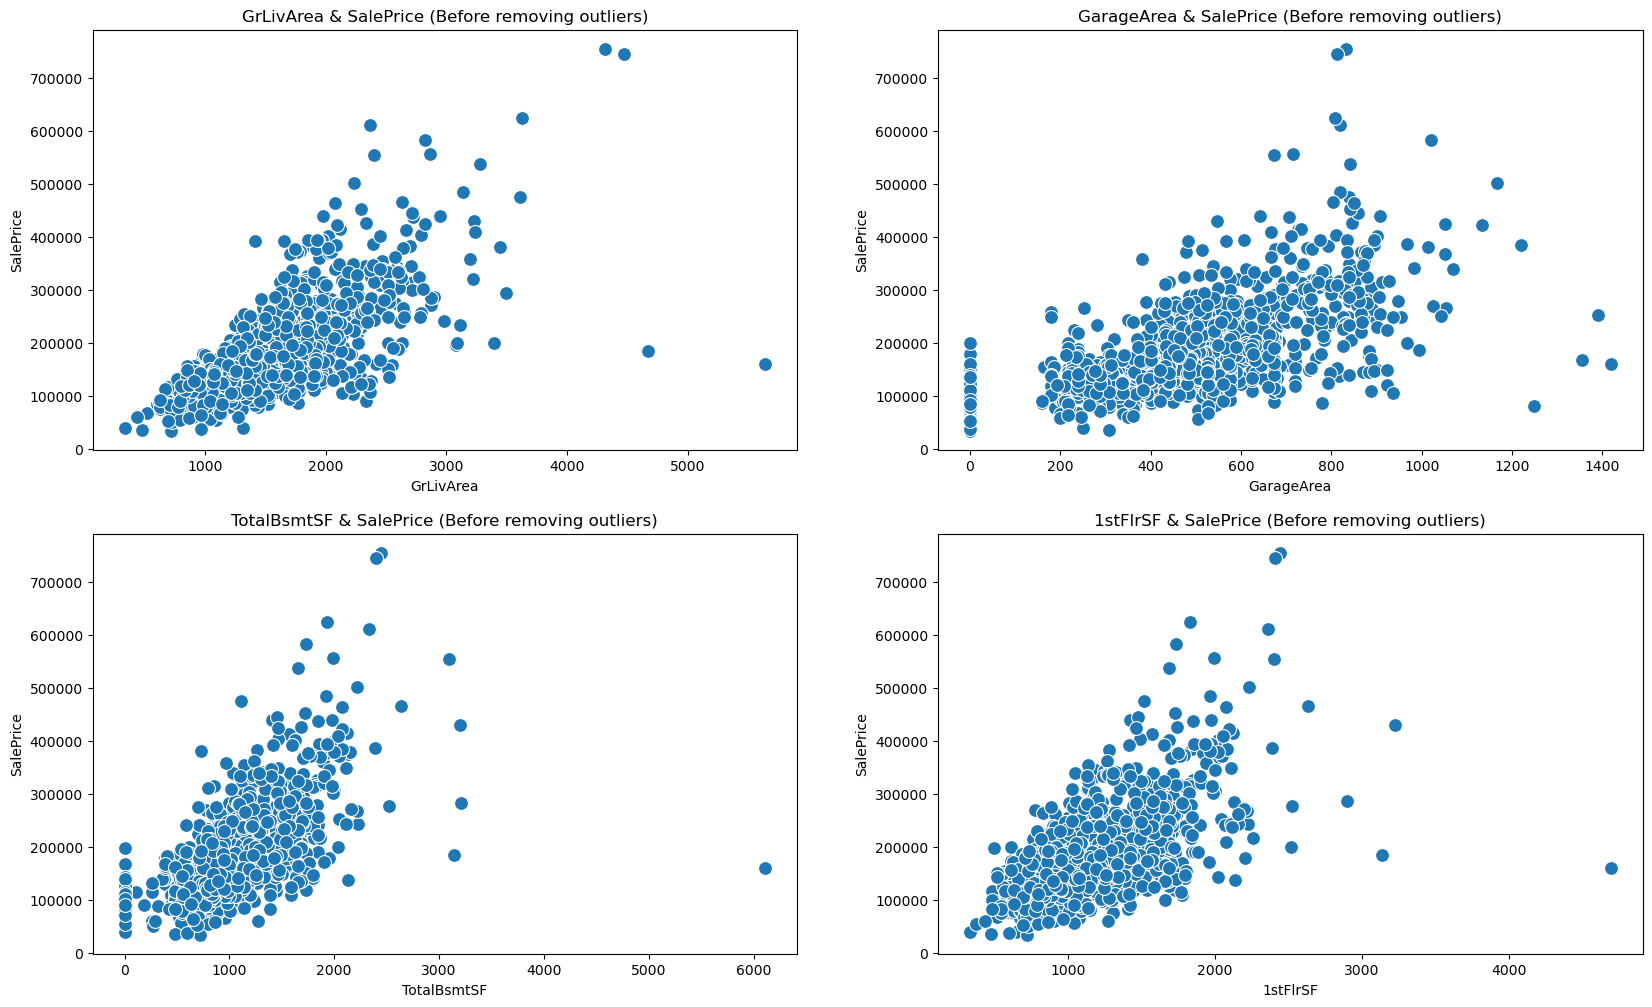

In [6]:
cols = [c for c in data.columns if data[c].nunique() > 30]

data_numeric = data[cols].select_dtypes(include=[np.number])
corr = data_numeric.corr()

print("Correlation of X and SalePrice")
print (corr['SalePrice'].sort_values())

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

best_columns = ['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']
for i,c in enumerate(best_columns):
    sns.scatterplot(data, x=c, y='SalePrice', ax=axs[i//2, i%2], s=100).set_title(f'{c} & SalePrice (Before removing outliers)')

plt.show()

## Removing outliers

When removing outliers, I considered only the features with the highest Pearson correlation coefficient with SalePrice. Based on the plots, I removed observations where the house feature values were clearly extreme.

1451


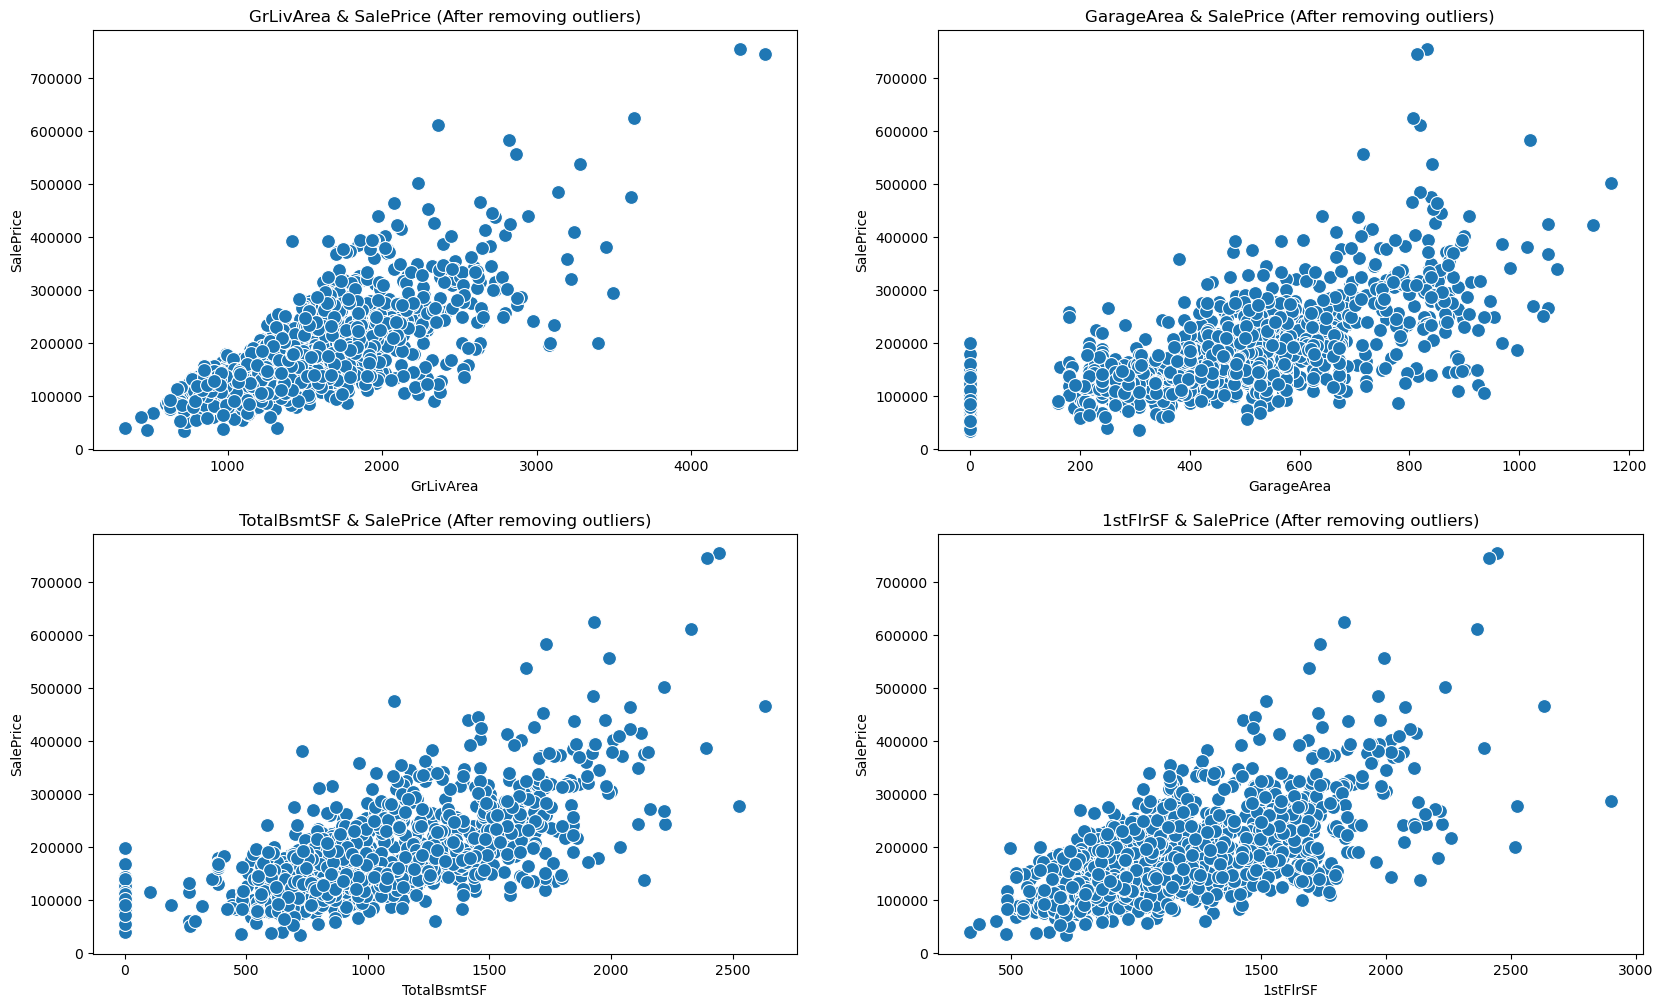

In [7]:
# data = data[data['SalePrice']<500000]
data = data[data['GrLivArea']<4500]
data = data[data['GarageArea']<1200]
data = data[data['TotalBsmtSF']<3000]
data = data[data['1stFlrSF']<2900]
print(len(data))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

for i,c in enumerate(best_columns):
    sns.scatterplot(data, x=c, y='SalePrice', ax=axs[i//2, i%2], s=100).set_title(f'{c} & SalePrice (After removing outliers)')

plt.show()

# Handling Ordinal Range Values

Ordinal range values are handled by mapping them to numerical representations using the change_to_num function.

In [8]:
def change_to_num(df):
    lotShapeMap = {'IR3':0, 'IR2': 1, 'IR1':2, 'Reg':3}
    landContourMap = {'Low': 0, 'Lvl':1, 'Bnk':2, 'HLS':3}
    qualityMap = {np.nan: 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
    fenceQualityMap = {np.nan: 0,'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4}
    garageFinishMap = {np.nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
    bsmtFinTypeMap = {np.nan:0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6}
    bsmtExposureMap = {np.nan: 0,'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

    df['LotShape'] = df['LotShape'].map(lotShapeMap)
    df['LandContour'] = df['LandContour'].map(landContourMap)

    df['ExterQual'] = df['ExterQual'].map(qualityMap)
    df['ExterCond'] = df['ExterCond'].map(qualityMap)
    df['BsmtQual'] = df['BsmtQual'].map(qualityMap)

    df['BsmtCond'] = df['BsmtCond'].map(qualityMap)
    df['BsmtExposure'] = df['BsmtExposure'].map(bsmtExposureMap)
    df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmtFinTypeMap)

    df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmtFinTypeMap)
    df['HeatingQC'] = df['HeatingQC'].map(qualityMap)
    df['KitchenQual'] = df['KitchenQual'].map(qualityMap)

    df['FireplaceQu'] = df['FireplaceQu'].map(qualityMap)
    df['GarageFinish'] = df['GarageFinish'].map(garageFinishMap)
    df['GarageQual'] = df['GarageQual'].map(qualityMap)

    df['GarageCond'] = df['GarageCond'].map(qualityMap)
    df['PoolQC'] = df['PoolQC'].map(qualityMap)
    df['Fence'] = df['Fence'].map(fenceQualityMap)

    return df

# Handling missing values

NaN values need to be handled before machine learning. This section is divided into feature-based subsections.

1) Electrical:

   1. There is only one missing value in Electrical column.
   2. This is treated as a data error. Even if it is not, imputing it results in minimal data loss.

In [9]:
print('MasVnr...')
print(f'Area is 0: {len(data[data['MasVnrArea']==0])}')
print(f'Area less than 0: {len(data[data['MasVnrArea']<0])}')

print(f'Area is Nan: {len(data[data['MasVnrArea'].isna()])}')
print(f'Type is Nan: {len(data[data['MasVnrType'].isna()])}')
print(f'Type is Nan and Area is 0: {len(data[(data['MasVnrType'].isna()) & (data['MasVnrArea']==0)])}')
print(f'Type is Nan and Area is Nan: {len(data[(data['MasVnrType'].isna()) & (data['MasVnrArea'].isna())])}')
print(f'Type is Nan and Area > 0: {len(data[(data['MasVnrType'].isna()) & (data['MasVnrArea']>0)])}')
print(f'Type is not Nan and Area is 0: {len(data[(data['MasVnrType'].notna()) & (data['MasVnrArea']==0)])}')
print(f'Type is not Nan and Area is Nan: {len(data[(data['MasVnrType'].notna()) & (data['MasVnrArea'].isna())])}')
print('\n')
print('Type is not Nan and Area is 0:')
display((data[(data['MasVnrType'].notna()) & (data['MasVnrArea']==0)])[['MasVnrType', 'MasVnrArea']])

MasVnr...
Area is 0: 859
Area less than 0: 0
Area is Nan: 8
Type is Nan: 870
Type is Nan and Area is 0: 857
Type is Nan and Area is Nan: 8
Type is Nan and Area > 0: 5
Type is not Nan and Area is 0: 2
Type is not Nan and Area is Nan: 0


Type is not Nan and Area is 0:


,MasVnrType,MasVnrArea
688,BrkFace,0.0
1241,Stone,0.0


2) Masonry Veneer (MasVnrArea and MasVnrType)

    1. If MasVnrArea is 0 or missing (NaN), it usually indicates that the house does not have a masonry veneer.

    2. If both MasVnrType and MasVnrArea are NaN, it is likely a case where MasVnrArea was mistakenly left blank instead of 0.

    3. If MasVnrType is not missing but MasVnrArea is 0, or if MasVnrType is NaN and MasVnrArea is greater than 0, this is probably a data entry error and should be treated as such.

In general, when both MasVnrType and MasVnrArea are missing, MasVnrArea is imputed with 0.

3) Bsmt (BsmtFinType1, BsmtCond, BsmtQual, BsmtExposure, BsmtFinType2):

    1. Nan value in Bsmt... column == no basement.
    2. Houses without a basement are handled in the change_to_num function. Missing values are encoded appropriately.

4) Garage (GarageType, GarageYrBlt, GarageCond, GarageQual, GarageFinish):

    1. Nan value in Garage... column == no garage.
    2. Houses without a garage are handled in the change_to_num function for all columns except GarageYrBlt.
    3. Missing GarageYrBlt values are imputed with the mean construction year of all garages.

5) FireplaceQu:

    1. Nan value in FireplaceQu column == no fireplace.
    2. Houses without a fireplace are handled in the change_to_num function. Missing values are encoded appropriately.

6) PoolQC:


    1. Nan value in PoolQC column == no pool.
    2. Houses without a pool are handled in the change_to_num function. Missing values are encoded appropriately.

7) Alley:

   1. Nan value in Alley == no alley.
   2. Houses without an alley are handled in the change_to_num function. Missing values are encoded appropriately.

8) Fence:

   1. Nan value in Fence == no fence.
   2. Houses without an fence are handled in the change_to_num function. Missing values are encoded appropriately.

9) MiscFeature:

   1. Nan value in MiscFeature == no miscellaneous features.
   2. Houses without an miscellaneous features are handled in the change_to_num function. Missing values are encoded appropriately.

In [10]:
print(f'LotFrontage is Nan: {len(data[data['LotFrontage'].isna()])}')
print(f'Street is Nan: {len(data[data['Street'].isna()])}')
print(f'LotFrontage is Nan and Allay is not Nan: {len(data[(data['LotFrontage'].isna()) & (data['Alley'].notna())])}')

LotFrontage is Nan: 257
Street is Nan: 0
LotFrontage is Nan and Allay is not Nan: 5


10) LotFrontage

There are two possible explanations for missing values in LotFrontage:
either all NaNs correspond to condos, or the houses do not have direct street access and are connected only via an alley.

However:

1. The dataset contains only houses (according to MSSubClass in data_description.txt).

2. Only 5 houses do not have street access but have alley access.

3. None of the houses have Nan values in the Street feature, which suggests that every house has street access.

Therefore, I assume that Nan values in LotFrontage result from data loss and should be imputed.

Most valuable variables for predicting LotFrontage:

1. Lot area or 1stFlrSF (First Floor square feet):

    The linear frontage along the street mostly depends on the overall property size.

2. LotShape:

    Irregularly shaped parcels are more likely to have smaller street connection.

3. LotConfig:

    Properties with more street exposure (Corner, FR2, FR3) tend to have larger LotFrontage
   

4. LandContour:

    Cars and pedestrians generally prefere flat terrain, so properties on hills are prone to have a shorter street frontage.

5. Neighborhood:
    
    Houses in the same neighbourhood often shre similar construction patterns.

## Strategy for LotFrontage

Start with a baseline model using the mean of known LotFrontage and then test two more advanced models:
1. Linear Regression
2. Random Forest Regressor

to predict missing LotFrontage

In [11]:
class Baseline:
    def __init__(self):
        self.mean = None

    def fit(self, train_y):
        self.mean = train_y.mean()

    def predict(self, test_X):
        return np.full(len(test_X), self.mean)

df = change_to_num(data.copy())
df = df.dropna(subset=['LotFrontage'])

X = df.drop('LotFrontage', axis=1)
y = df['LotFrontage']

_, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = Baseline()
model.fit(df['LotFrontage'])
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'MAE of Baseline model: {mae}, MSE of Baseline model: {mse}')

MAE of Baseline model: 15.484322727845354, MSE of Baseline model: 471.0432732222738


In [12]:
df = change_to_num(data.copy())
unknown_columns = ['SaleCondition', 'SaleType', 'YrSold', 'MoSold']

def train_model_LotFrontage(df1, model, columns=None):

    df = df1.copy()

    if columns:
        df = pd.concat([df[columns], df['LotFrontage']], axis=1)
    else:
        df = df.drop(unknown_columns, axis=1) # to prevent data leakage
    df = df.dropna(subset=['LotFrontage'])

    string_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=string_cols, drop_first=True, dummy_na=True)

    X = df.drop('LotFrontage', axis=1)
    y = df['LotFrontage']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    mse = mean_squared_error(y_test, y_pred)
    return model, X.columns, mae,mse


lr_model = LinearRegression()
lr_model, train_cols, mae, mse = train_model_LotFrontage(df, lr_model, columns=['LotArea', 'LotShape', 'LotConfig', 'LandContour', 'Neighborhood'])
print(f'MAE of Linear Regression model: {mae}, MSE of Linear Regression model: {mse}')

rf_model = RandomForestRegressor(n_estimators=400, max_depth=4, random_state=42)
rf_model, train_cols, mae, mse = train_model_LotFrontage(df, rf_model)
print(f'MAE of Radom Forest model: {mae}, MSE of Radom Forest model: {mse}')

MAE of Linear Regression model: 11.741096054887251, MSE of Linear Regression model: 765.7951111425944
MAE of Radom Forest model: 9.809246533067128, MSE of Radom Forest model: 221.97652368258963


1) MAE of Baseline model: 15.93, MSE: 479.63
2) MAE of Linear Regression model: 12.34, MSE: 804.18
3) MAE of Random Forest model: 10.41, MSE: 233.33

The most important metric for predicting LotFrontage is MSE, as large prediction errors are particularly undesirable.
Since the Random Forest model achieves the lowest MSE, it is selected as the final model for imputing missing LotFrontage values.

# Preprocess data function

In [13]:
def remove_nan(df): 
    ## Electrical
    df = df.dropna(subset=['Electrical'])

    ## MasVnrType - anti-join
    df2 = df[
        (df['MasVnrType'].isna() & (df['MasVnrArea'] > 0)) |
        (df['MasVnrType'].notna() & (df['MasVnrArea'] == 0))
    ]

    df = df.merge(df2.drop_duplicates(), how='left', indicator=True)
    df = df[df['_merge']=='left_only'].drop(['_merge'], axis=1)

    df.loc[(df['MasVnrType'].isna()) & (df['MasVnrArea'].isna()), ['MasVnrArea']] = 0
    return df


def preprocess_data(df):
    # Fill Nan's
    
    ## Garage - year (mean)
    mean_garage_year = df.loc[df['GarageYrBlt'].notna(), 'GarageYrBlt'].mean()
    df.loc[df['GarageYrBlt'].isna(), 'GarageYrBlt'] = mean_garage_year

    ## LotFrontage - Random forests!
    
    X_missing = df.loc[df['LotFrontage'].isna()].drop('LotFrontage', axis=1)
    X_missing = X_missing.reindex(columns=train_cols, fill_value=0)
    if len(X_missing)>0: 
        df.loc[df['LotFrontage'].isna(), 'LotFrontage'] = rf_model.predict(X_missing)

    return df
    
# df = process_data(df)
# missing = df.isna().sum().loc[lambda x: x > 0].sort_values()
# display(missing) #result: 0

# Feature engineering

In [14]:
def add_features(df):
    df = df.copy()
    df['Pool'] = df['PoolQC'].notna().astype(int)
    df['TotalBath'] = df['BsmtFullBath']+df['BsmtHalfBath']+df['FullBath']+df['HalfBath']
    return df

# Final Train Data Transformation

In [15]:
from sklearn.model_selection import train_test_split

df = data.copy()
df = remove_nan(df)
df = change_to_num(df)

string_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=string_cols, drop_first=True, dummy_na=True)
df = add_features(df)

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])
X = preprocess_data(X)

# ML

## Prepare test data

In [19]:
test_data = test.copy()

test_data = remove_nan(test_data)
test_data = change_to_num(test_data)

string_cols = test_data.select_dtypes(include='object').columns
test_data = pd.get_dummies(test_data, columns=string_cols, drop_first=True, dummy_na=True)
test_data = add_features(test_data)
test_data = test_data.reindex(columns=X.columns, fill_value=0)

test_data = preprocess_data(X)

missing = test_data.isna().sum().loc[lambda x: x > 0].sort_values()
print('NAN values in train data:\n')
display(missing)

NAN values in train data:



Series([], dtype: int64)

## HERE

will be linear regression and radom forest models.